# Census Demographics & Restaurant Info

In [1]:
# Dependencies
import matplotlib.pyplot as plt
import gmaps
import numpy as np
import pandas as pd
import requests
import time
import json
from census import Census
from jconfig import (api_key, gkey)
from uszipcode import SearchEngine, SimpleZipcode, Zipcode


# Census API Key
c = Census(api_key, year=2017)

# Define Market Area and create DataFrame 

In [2]:
#read in zip.csv
zip_pd = pd.read_csv("zip.csv")

#clear any null values
zip_pd.dropna(inplace= True)

#filter df to only include standard zip codes(exclude unique and p.o. boxes)
std_pd= zip_pd.loc[zip_pd.Type=="Standard"]

In [5]:
#filter to only include zip codes in Dallas County
county_zip_pd= std_pd.loc[(std_pd["County"]== "Dallas") | (std_pd["County"]== "Tarrant") | (std_pd["County"]== "Collin") | (std_pd["County"]== "Denton")]

#extract all zip codes in Dallas County to a list
county_zips = county_zip_pd["Zip Code"].tolist()
city_zips = county_zip_pd["City"].tolist()

#create lists for lat and long per zip code
lat=[]
long=[]
rest_count = []
for z in county_zips:
    search= SearchEngine()
    zipcode= search.by_zipcode(z)
    latitude= zipcode.lat
    lat.append(latitude)
    longitude= zipcode.lng
    long.append(longitude)
    
for z in county_zips:
   ykey='zb0GcvgfwyjRcY9Rw-V7CCINzDGu8fCRO0_5z6EAN0T77jh1n7Q8Xk87pi33DOK2a0pS19XzrsODFhojo1xyWWkz1D0UTOtW6IeFv5jdoml6ROzSYLBYFddnLtMmXXYx'
   headers = {'Authorization': 'Bearer %s' % ykey}
   url = 'https://api.yelp.com/v3/businesses/search'
   params = {'term':'restaurant', 'locale':'en_US', 'location': z, 'offset': 0, 'limit': 50, 'radius': 1500}
   req = requests.get(url, params=params, headers=headers).json()
   total_res =req['total']
   rest_count.append(total_res)
    
#create dictionary
county_zips_dict={"City": city_zips,"Zip_Codes": county_zips,"Lat":lat, "Lon":long, "Rest_Count":rest_count}

#convert list to DF in order to merge later with Census data
county_zip_df= pd.DataFrame(county_zips_dict)
county_zip_df.head()

,City,Zip_Codes,Lat,Lon,Rest_Count
0,Addison,75001,32.96,-96.84,120
1,Allen,75002,33.08,-96.61,3
2,Carrollton,75006,32.95,-96.89,53
3,Carrollton,75007,33.00,-96.90,26
4,Celina,75009,33.30,-96.80,0


In [4]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
county_zip_df.to_csv("CityCounty_zip_data.csv", encoding="utf-8", index=False)

# Create Census DataFrame for Market Area

In [6]:
# Run Census Search to retrieve data on all cities
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Name", "zip code tabulation area": "Zip_Codes"})
#convert Zip Codes to numeric, in order to merge later
census_pd.Zip_Codes= pd.to_numeric(census_pd.Zip_Codes)
census_pd.head()

,Median Age,Population,Household Income,Per Capita Income,Name,Zip_Codes
0,38.9,17599.0,11757.0,7041.0,ZCTA5 00601,601
1,40.9,39209.0,16190.0,8978.0,ZCTA5 00602,602
2,40.4,50135.0,16645.0,10897.0,ZCTA5 00603,603
3,42.8,6304.0,13387.0,5960.0,ZCTA5 00606,606
4,41.4,27590.0,18741.0,9266.0,ZCTA5 00610,610


In [7]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
census_pd.to_csv("census_data.csv", encoding="utf-8", index=False)

In [8]:
# merge Zip DF with Census DF
zip_census_merge= pd.merge(county_zip_df,census_pd, on="Zip_Codes")
zip_census_merge.head()

,City,Zip_Codes,Lat,Lon,Rest_Count,Median Age,Population,Household Income,Per Capita Income,Name
0,Addison,75001,32.96,-96.84,120,32.9,14617.0,73578.0,50313.0,ZCTA5 75001
1,Allen,75002,33.08,-96.61,3,35.7,69688.0,98652.0,39818.0,ZCTA5 75002
2,Carrollton,75006,32.95,-96.89,53,34.8,50788.0,57415.0,27810.0,ZCTA5 75006
3,Carrollton,75007,33.00,-96.90,26,39.5,53744.0,82079.0,36289.0,ZCTA5 75007
4,Celina,75009,33.30,-96.80,0,37.5,10557.0,90717.0,36058.0,ZCTA5 75009


# Population DataFrame 

In [9]:
# Male population data for 15-44yr olds
male_age_data = c.acs5.get(("NAME", "B01001_006E","B01001_007E","B01001_008E","B01001_009E","B01001_010E","B01001_011E",
                      "B01001_012E","B01001_013E","B01001_014E"), {'for': 'zip code tabulation area:*'})

# Female population data for 15-44yr olds
female_age_data = c.acs5.get(("NAME", "B01001_030E","B01001_031E","B01001_032E","B01001_033E","B01001_034E","B01001_035E",
                      "B01001_036E","B01001_037E","B01001_038E"), {'for': 'zip code tabulation area:*'})
# Convert to DataFrame
male_pd = pd.DataFrame(male_age_data)
male_pd= male_pd.rename(columns={"zip code tabulation area": "Zip_Codes"})
female_pd= pd.DataFrame(female_age_data)
female_pd= female_pd.rename(columns={"zip code tabulation area": "Zip_Codes"})

In [10]:
# Total population by gender
male_pd["Total_Male"]= male_pd.B01001_006E + male_pd.B01001_007E + male_pd.B01001_008E + male_pd.B01001_009E \
    + male_pd.B01001_010E + male_pd.B01001_011E + male_pd.B01001_012E + male_pd.B01001_013E + male_pd.B01001_014E
female_pd["Total_Female"]= female_pd.B01001_030E + female_pd.B01001_031E + female_pd.B01001_032E + female_pd.B01001_033E \
    + female_pd.B01001_034E + female_pd.B01001_035E + female_pd.B01001_036E + female_pd.B01001_037E + female_pd.B01001_038E

# merge Male and Female df's
gender_merge= pd.merge(male_pd,female_pd, on="Zip_Codes")

# calculate new column for total 15-44 yr olds
gender_merge.loc[:,"Pop_15to44"]=gender_merge.Total_Male + gender_merge.Total_Female

# filter DF to include only Total and Zip Codes
gender_df = gender_merge[["Pop_15to44", "Zip_Codes"]]

# convert Zip_codes to numeric
gender_df.Zip_Codes= pd.to_numeric(gender_df.Zip_Codes)

# merge gender_df with zip_census_merge
demographic_df = pd.merge(zip_census_merge,gender_df, on="Zip_Codes")
demographic_df.head(10)

C:\Users\conta\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,City,Zip_Codes,Lat,Lon,Rest_Count,Median Age,Population,Household Income,Per Capita Income,Name,Pop_15to44
0,Addison,75001,32.96,-96.84,120,32.9,14617.0,73578.0,50313.0,ZCTA5 75001,8826.0
1,Allen,75002,33.08,-96.61,3,35.7,69688.0,98652.0,39818.0,ZCTA5 75002,28557.0
2,Carrollton,75006,32.95,-96.89,53,34.8,50788.0,57415.0,27810.0,ZCTA5 75006,21488.0
3,Carrollton,75007,33.00,-96.90,26,39.5,53744.0,82079.0,36289.0,ZCTA5 75007,21743.0
4,Celina,75009,33.30,-96.80,0,37.5,10557.0,90717.0,36058.0,ZCTA5 75009,4179.0
5,Carrollton,75010,33.03,-96.90,8,35.2,27822.0,81856.0,41328.0,ZCTA5 75010,13173.0
6,Allen,75013,33.12,-96.69,12,37.4,38975.0,124915.0,51388.0,ZCTA5 75013,15089.0
7,Coppell,75019,32.96,-96.98,52,40.3,41947.0,118471.0,54352.0,ZCTA5 75019,15538.0
8,Flower Mound,75022,33.03,-97.12,0,40.6,24625.0,156902.0,59110.0,ZCTA5 75022,8358.0
9,Plano,75023,33.05,-96.73,9,39.5,49563.0,83764.0,37519.0,ZCTA5 75023,19871.0


In [23]:
# Create a new DF and grabbing the Location Data to check for 0
newdf=demographic_df[['City','Lat','Lon','Pop_15to44','Population', 'Rest_Count']]
newdf = newdf[newdf.Pop_15to44 != 0]
newdf.head()

,City,Lat,Lon,Pop_15to44,Population,Rest_Count
0,Addison,32.96,-96.84,8826.0,14617.0,120
1,Allen,33.08,-96.61,28557.0,69688.0,3
2,Carrollton,32.95,-96.89,21488.0,50788.0,53
3,Carrollton,33.00,-96.90,21743.0,53744.0,26
4,Celina,33.30,-96.80,4179.0,10557.0,0


# Create a Heatmap for Population Density & Restaurant Density

In [24]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [25]:
pop_rate = newdf['Population'] / 10000
coord_pair = [(xy) for xy in zip(newdf.Lat, newdf.Lon)]
newdf["Coordinates"]= coord_pair

locations = newdf["Coordinates"]
newdf.head()

,City,Lat,Lon,Pop_15to44,Population,Rest_Count,Coordinates
0,Addison,32.96,-96.84,8826.0,14617.0,120,"(32.96, -96.84)"
1,Allen,33.08,-96.61,28557.0,69688.0,3,"(33.08, -96.61)"
2,Carrollton,32.95,-96.89,21488.0,50788.0,53,"(32.95, -96.89)"
3,Carrollton,33.00,-96.90,21743.0,53744.0,26,"(33.0, -96.9)"
4,Celina,33.30,-96.80,4179.0,10557.0,0,"(33.3, -96.8)"


In [26]:
figure_layout={
   'width': '800px',
   'height': '800px',
   'border': '1px solid black',
   'padding': '1px'
}
fig = gmaps.figure(map_type="TERRAIN", layout=figure_layout)
heat_layer= gmaps.heatmap_layer(locations,weights = newdf.Population,
                        dissipating=False, max_intensity=.001,
                       point_radius=.050)

fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

In [27]:
figure_layout={
   'width': '800px',
   'height': '800px',
   'border': '1px solid black',
   'padding': '1px'
}
fig = gmaps.figure(map_type="TERRAIN", layout=figure_layout)
heat_layer= gmaps.heatmap_layer(locations, weights = newdf.Rest_Count,
                        dissipating=False, max_intensity=.5,
                       point_radius=.05)

fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

# Find the Top Zip Codes by Population Denisty & Household Income 

In [28]:
#getting the top ten household incomes
sorted_max = zip_census_merge.sort_values('Household Income', ascending=False)
max = sorted_max[0:10]
max

,City,Zip_Codes,Lat,Lon,Rest_Count,Median Age,Population,Household Income,Per Capita Income,Name
146,Southlake,76092,32.96,-97.15,1,42.1,30138.0,207127.0,79825.0,ZCTA5 76092
88,Dallas,75225,32.87,-96.79,15,45.7,21568.0,173828.0,117586.0,ZCTA5 75225
136,Colleyville,76034,32.89,-97.14,39,47.8,25557.0,164682.0,74123.0,ZCTA5 76034
8,Flower Mound,75022,33.03,-97.12,0,40.6,24625.0,156902.0,59110.0,ZCTA5 75022
66,Sunnyvale,75182,32.79,-96.56,6,38.0,6077.0,137721.0,48606.0,ZCTA5 75182
42,Prosper,75078,33.26,-96.82,3,34.4,20611.0,136642.0,49613.0,ZCTA5 75078
188,Argyle,76226,33.12,-97.17,0,40.7,25037.0,130720.0,54079.0,ZCTA5 76226
71,Dallas,75205,32.83,-96.79,71,34.4,24211.0,129406.0,98860.0,ZCTA5 75205
49,Plano,75094,33.01,-96.62,50,37.4,23097.0,127095.0,40336.0,ZCTA5 75094
6,Allen,75013,33.12,-96.69,12,37.4,38975.0,124915.0,51388.0,ZCTA5 75013


In [29]:
# getting the ten lowest incomes 
sorted_min = zip_census_merge.sort_values('Household Income', ascending=True)
sorted_min.head(5)

,City,Zip_Codes,Lat,Lon,Rest_Count,Median Age,Population,Household Income,Per Capita Income,Name
114,Dallas,75270,32.7813,-96.8017,356,-666666666.0,0.0,-666666666.0,-666666666.0,ZCTA5 75270
107,Dallas,75247,32.8300,-96.8800,39,59.6,712.0,16886.0,13393.0,ZCTA5 75247
81,Dallas,75216,32.7100,-96.7700,3,34.2,52895.0,25763.0,13027.0,ZCTA5 75216
76,Dallas,75210,32.7600,-96.7400,9,30.4,8243.0,25793.0,11578.0,ZCTA5 75210
149,Fort Worth,76104,32.7300,-97.3200,42,30.9,18199.0,26140.0,14565.0,ZCTA5 76104


In [30]:
#dropping the first three rows for better data
new_sorted_min = sorted_min.iloc[3:]
new_sorted_min
min = new_sorted_min[0:10]
min

,City,Zip_Codes,Lat,Lon,Rest_Count,Median Age,Population,Household Income,Per Capita Income,Name
76,Dallas,75210,32.760,-96.740,9,30.4,8243.0,25793.0,11578.0,ZCTA5 75210
149,Fort Worth,76104,32.730,-97.320,42,30.9,18199.0,26140.0,14565.0,ZCTA5 76104
106,Dallas,75246,32.793,-96.773,140,35.3,2276.0,26716.0,32734.0,ZCTA5 75246
100,Dallas,75237,32.660,-96.870,26,27.2,20295.0,26768.0,13956.0,ZCTA5 75237
182,Denton,76201,33.220,-97.150,65,23.0,28038.0,27232.0,15948.0,ZCTA5 76201
80,Dallas,75215,32.750,-96.770,6,39.5,15664.0,27358.0,17301.0,ZCTA5 75215
150,Fort Worth,76105,32.720,-97.270,20,28.9,21661.0,28843.0,12437.0,ZCTA5 76105
78,Dallas,75212,32.780,-96.870,4,28.1,26120.0,30673.0,12626.0,ZCTA5 75212
103,Dallas,75241,32.670,-96.760,5,36.0,29398.0,32652.0,16519.0,ZCTA5 75241
69,Dallas,75203,32.740,-96.790,7,32.3,16351.0,32699.0,18696.0,ZCTA5 75203


In [31]:
max.head()

,City,Zip_Codes,Lat,Lon,Rest_Count,Median Age,Population,Household Income,Per Capita Income,Name
146,Southlake,76092,32.96,-97.15,1,42.1,30138.0,207127.0,79825.0,ZCTA5 76092
88,Dallas,75225,32.87,-96.79,15,45.7,21568.0,173828.0,117586.0,ZCTA5 75225
136,Colleyville,76034,32.89,-97.14,39,47.8,25557.0,164682.0,74123.0,ZCTA5 76034
8,Flower Mound,75022,33.03,-97.12,0,40.6,24625.0,156902.0,59110.0,ZCTA5 75022
66,Sunnyvale,75182,32.79,-96.56,6,38.0,6077.0,137721.0,48606.0,ZCTA5 75182


In [32]:
max['Zip_Codes']

146    76092
88     75225
136    76034
8      75022
66     75182
42     75078
188    76226
71     75205
49     75094
6      75013
Name: Zip_Codes, dtype: int64

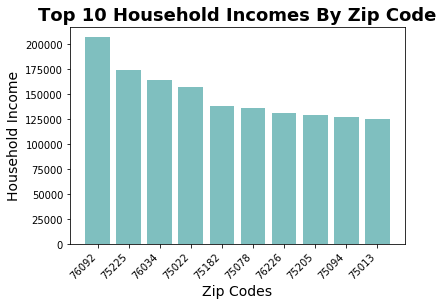

In [33]:
users = max['Household Income']
x_axis = np.arange(len(users))
plt.bar(x_axis, users, color='teal', alpha=0.5, align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations,['76092', '75225', '76034', '75022', '75182', '75078', '76226', '75205', '75094', '75013'], rotation=45, ha='right')
plt.title("Top 10 Household Incomes By Zip Code", fontsize=18, fontweight='bold')
plt.xlabel("Zip Codes", fontsize=14)
plt.ylabel("Household Income", fontsize=14)
plt.show()

In [34]:
s_max = max.sort_values('Population', ascending=False)
s_max.head(10)

,City,Zip_Codes,Lat,Lon,Rest_Count,Median Age,Population,Household Income,Per Capita Income,Name
6,Allen,75013,33.12,-96.69,12,37.4,38975.0,124915.0,51388.0,ZCTA5 75013
146,Southlake,76092,32.96,-97.15,1,42.1,30138.0,207127.0,79825.0,ZCTA5 76092
136,Colleyville,76034,32.89,-97.14,39,47.8,25557.0,164682.0,74123.0,ZCTA5 76034
188,Argyle,76226,33.12,-97.17,0,40.7,25037.0,130720.0,54079.0,ZCTA5 76226
8,Flower Mound,75022,33.03,-97.12,0,40.6,24625.0,156902.0,59110.0,ZCTA5 75022
71,Dallas,75205,32.83,-96.79,71,34.4,24211.0,129406.0,98860.0,ZCTA5 75205
49,Plano,75094,33.01,-96.62,50,37.4,23097.0,127095.0,40336.0,ZCTA5 75094
88,Dallas,75225,32.87,-96.79,15,45.7,21568.0,173828.0,117586.0,ZCTA5 75225
42,Prosper,75078,33.26,-96.82,3,34.4,20611.0,136642.0,49613.0,ZCTA5 75078
66,Sunnyvale,75182,32.79,-96.56,6,38.0,6077.0,137721.0,48606.0,ZCTA5 75182


In [35]:
s_max['Zip_Codes']

6      75013
146    76092
136    76034
188    76226
8      75022
71     75205
49     75094
88     75225
42     75078
66     75182
Name: Zip_Codes, dtype: int64

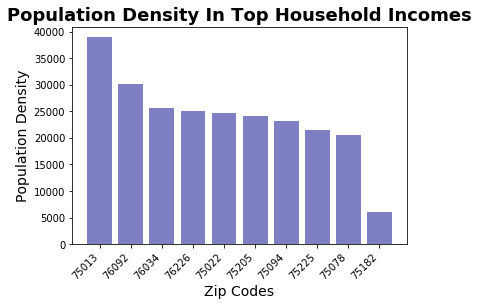

In [36]:
users = s_max['Population']
x_axis = np.arange(len(users))
plt.bar(x_axis, users, color='darkblue', alpha=0.5, align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations,['75013','76092','76034','76226','75022','75205','75094','75225','75078','75182'], rotation=45, ha='right')
plt.title("Population Density In Top Household Incomes", fontsize=18, fontweight='bold')
plt.xlabel("Zip Codes", fontsize=14)
plt.ylabel("Population Density", fontsize=14)
plt.show()

In [37]:
#getting the top ten for population
sorted_population = zip_census_merge.sort_values('Population', ascending=False)
max = sorted_population[0:9]
max

,City,Zip_Codes,Lat,Lon,Rest_Count,Median Age,Population,Household Income,Per Capita Income,Name
13,Frisco,75034,33.12,-96.88,20,36.4,95996.0,116962.0,50792.0,ZCTA5 75034
25,Grand Prairie,75052,32.65,-97.02,3,34.9,94133.0,74859.0,27888.0,ZCTA5 75052
37,Mckinney,75070,33.16,-96.72,11,36.2,93299.0,98754.0,41844.0,ZCTA5 75070
82,Dallas,75217,32.70,-96.68,8,28.6,85249.0,35282.0,12792.0,ZCTA5 75217
77,Dallas,75211,32.74,-96.92,9,28.4,77600.0,38760.0,14994.0,ZCTA5 75211
91,Dallas,75228,32.83,-96.68,28,31.0,74605.0,40306.0,19520.0,ZCTA5 75228
190,Keller,76244,32.93,-97.28,8,32.1,74414.0,100861.0,35829.0,ZCTA5 76244
1,Allen,75002,33.08,-96.61,3,35.7,69688.0,98652.0,39818.0,ZCTA5 75002
145,Mansfield,76063,32.57,-97.13,33,36.3,69146.0,93201.0,37655.0,ZCTA5 76063


# Highest Rated Cuisine 

In [38]:
cuisine_pd = pd.read_csv("DallasCuisineRating.csv")
#clear any null values
cuisine_pd['rating'].dropna(inplace= True)
cuisine_pd['rating'] = cuisine_pd['rating'].astype(object)
cuisine_pd['rating'].dtype
cuisine_pd.dtypes

ethnicity       object
name            object
address         object
price_level    float64
rating          object
dtype: object

In [39]:
ratings = cuisine_pd.sort_values('rating', ascending=False)
rating = ratings
rating.head()

,ethnicity,name,address,price_level,rating
18,new american,Gemma,"2323 N Henderson Ave #109, Dallas",2.0,4.7
11,israeli,Food From Galilee,"6710 Snider Plaza, Dallas",1.0,4.7
16,lebanese,Open Sesame Lebanese Grill,"2615 Oak Lawn Ave, Dallas",2.0,4.7
4,german,Kuby's Sausage House,"6601 Snider Plaza, Dallas",1.0,4.7
7,hungarian,Armoury D.E.,"2714 Elm St, Dallas",2.0,4.7


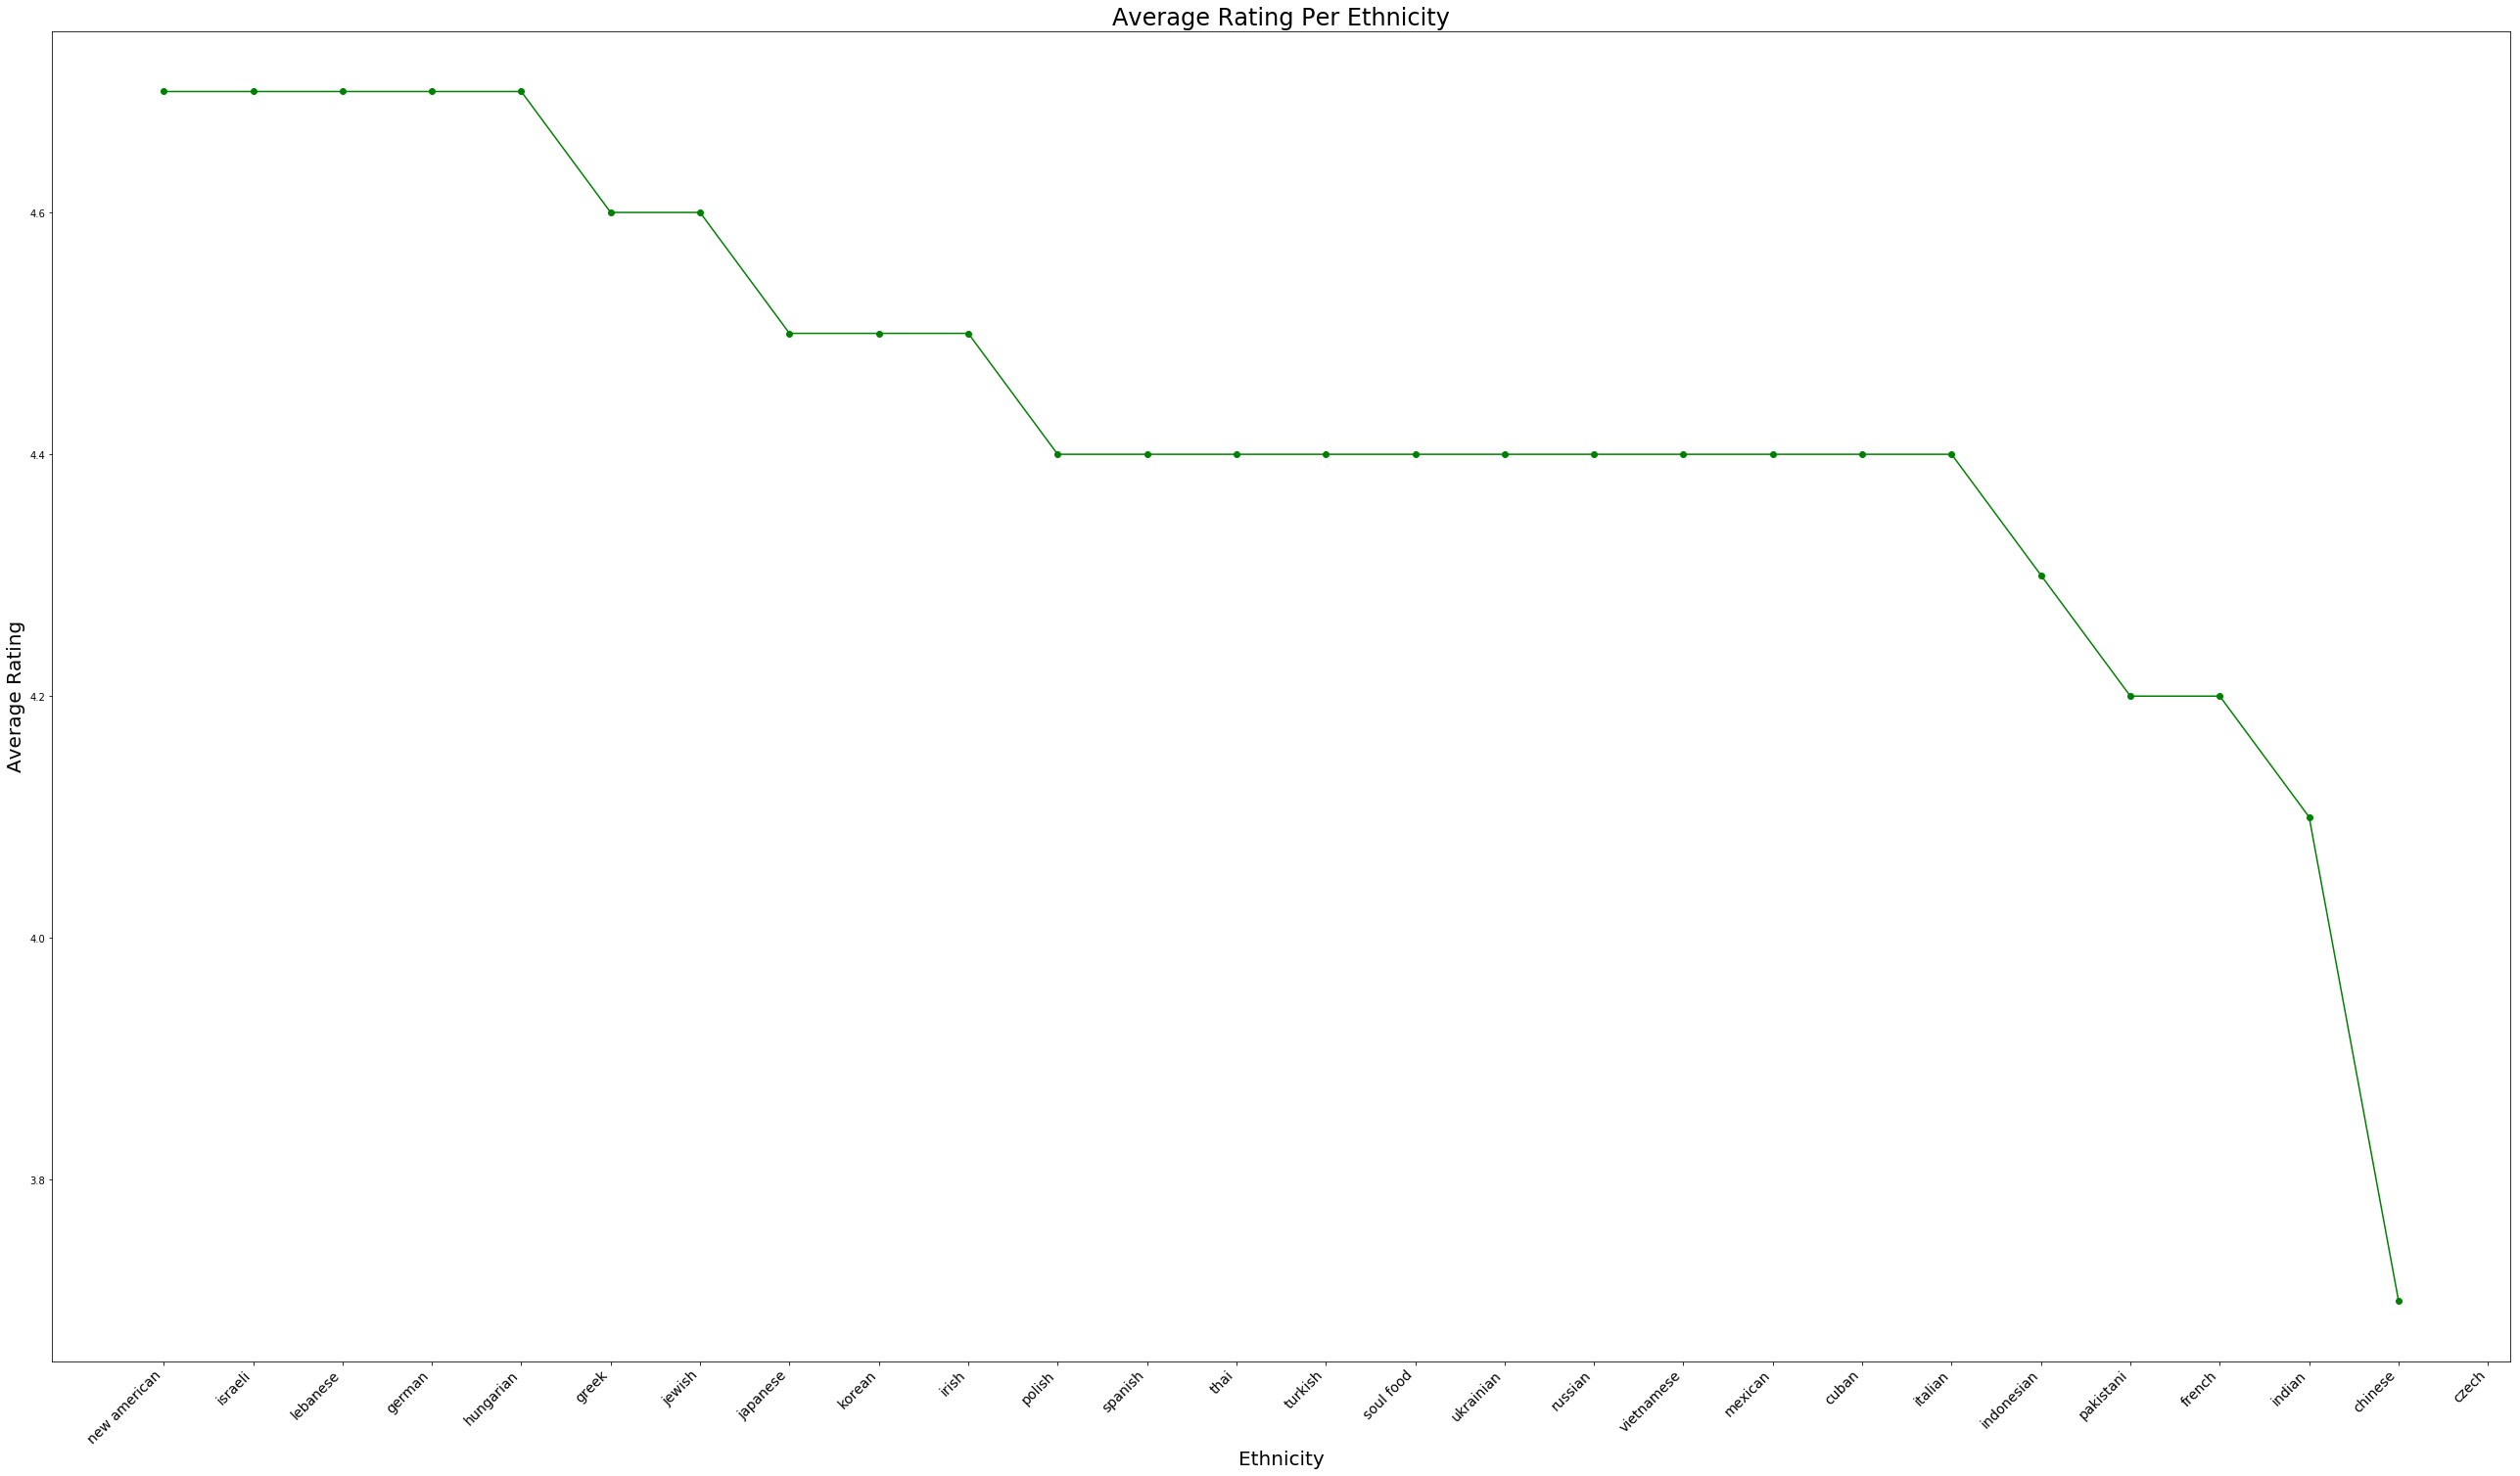

In [41]:
plt.plot(rating['ethnicity'], rating['rating'], color = 'green', label = 'line', marker = "o")
plt.rcParams['figure.figsize'] = (35,20)
plt.xticks(rotation = 45, ha = 'right', fontsize = 14)
plt.title("Average Rating Per Ethnicity", fontsize = 24)
plt.xlabel("Ethnicity", fontsize = 20)
plt.ylabel("Average Rating", fontsize = 20)
plt.show()

# Q& A